In [1]:
#Run Once
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
#!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
#Run Once
import os
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

In [3]:
# need to run twice to see spark dashboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-04-16 12:11:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.230.235.205, 34.192.46.56, 54.236.206.131, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.230.235.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14746350 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  14.06M  34.4MB/s    in 0.4s    

2021-04-16 12:11:33 (34.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [14746350/14746350]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


In [7]:


import pandas as pd
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import *
from pyspark.sql import functions as F
sc = spark.sparkContext
from pyspark.sql import Row
from pyspark.sql.functions import isnull, when, count, col

In [8]:
Final_X_Ydataset = spark.read.csv('/content/drive/MyDrive/Colab datasets/Final/Final_X_Y_3Hdataset_v3.csv', header = True, inferSchema=True)
Final_X_Ydataset.printSchema()

root
 |-- date: string (nullable = true)
 |-- rain_OAK_PARK: integer (nullable = true)
 |-- temp_OAK_PARK: double (nullable = true)
 |-- rhum_OAK_PARK: integer (nullable = true)
 |-- msl_OAK_PARK: double (nullable = true)
 |-- wdsp_OAK_PARK: integer (nullable = true)
 |-- wddir_OAK_PARK: integer (nullable = true)
 |-- rain_SHANNON_AIRPORT: integer (nullable = true)
 |-- temp_SHANNON_AIRPORT: double (nullable = true)
 |-- rhum_SHANNON_AIRPORT: integer (nullable = true)
 |-- msl_SHANNON_AIRPORT: double (nullable = true)
 |-- wdsp_SHANNON_AIRPORT: integer (nullable = true)
 |-- wddir_SHANNON_AIRPORT: integer (nullable = true)
 |-- rain_ATHENRY: integer (nullable = true)
 |-- temp_ATHENRY: double (nullable = true)
 |-- rhum_ATHENRY: integer (nullable = true)
 |-- msl_ATHENRY: double (nullable = true)
 |-- wdsp_ATHENRY: integer (nullable = true)
 |-- wddir_ATHENRY: integer (nullable = true)
 |-- rain_BELMULLET: integer (nullable = true)
 |-- temp_BELMULLET: double (nullable = true)
 |-- rhu

In [9]:
Final_X_Ydataset.describe().toPandas()

,summary,date,rain_OAK_PARK,temp_OAK_PARK,rhum_OAK_PARK,msl_OAK_PARK,wdsp_OAK_PARK,wddir_OAK_PARK,rain_SHANNON_AIRPORT,temp_SHANNON_AIRPORT,rhum_SHANNON_AIRPORT,msl_SHANNON_AIRPORT,wdsp_SHANNON_AIRPORT,wddir_SHANNON_AIRPORT,rain_ATHENRY,temp_ATHENRY,rhum_ATHENRY,msl_ATHENRY,wdsp_ATHENRY,wddir_ATHENRY,rain_BELMULLET,temp_BELMULLET,rhum_BELMULLET,msl_BELMULLET,wdsp_BELMULLET,wddir_BELMULLET,rain_CASEMENT,temp_CASEMENT,rhum_CASEMENT,msl_CASEMENT,wdsp_CASEMENT,wddir_CASEMENT,rain_CLAREMORRIS,temp_CLAREMORRIS,rhum_CLAREMORRIS,msl_CLAREMORRIS,wdsp_CLAREMORRIS,wddir_CLAREMORRIS,rain_CORK_AIRPORT,temp_CORK_AIRPORT,...,rain_Sherk_inIsland,temp_Sherk_inIsland,rhum_Sherk_inIsland,msl_Sherk_inIsland,wdsp_Sherk_inIsland,wddir_Sherk_inIsland,rain_VALENTIA_OBSERVATORY,temp_VALENTIA_OBSERVATORY,rhum_VALENTIA_OBSERVATORY,msl_VALENTIA_OBSERVATORY,wdsp_VALENTIA_OBSERVATORY,wddir_VALENTIA_OBSERVATORY,rain_Markree,temp_Markree,rhum_Markree,msl_Markree,wdsp_Markree,wddir_Markree,rain_BALLYHAISE,temp_BALLYHAISE,rhum_BALLYHAISE,msl_BALLYHAISE,wdsp_BALLYHAISE,wddir_BALLYHAISE,rain_Dunsany,temp_Dunsany,rhum_Dunsany,msl_Dunsany,wdsp_Dunsany,wddir_Dunsany,rain_Gurteen,temp_Gurteen,rhum_Gurteen,msl_Gurteen,wdsp_Gurteen,wddir_Gurteen,rain_sligo_Y3H,temp_sligo_Y3H,rhum_sligo_Y3H,msl_sligo_Y3H
0,count,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,...,87670,87670,87670,87670,87670,87670,87669,87669,87669,87669,87669,87669,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670,87670
1,mean,None,0.2795483061480552,10.125015398654057,82.761161172579,1012.6551614007111,7.554134823770959,211.1142922322345,0.37344587658263945,10.632958822858685,82.42224250028517,1013.4329177597947,9.182365689517509,191.80004562564162,0.4209193566784533,9.842591536443445,83.8633626097867,1011.3001140641081,7.476137789437664,201.2232234515798,0.45441998403102546,10.445329074940217,82.52396486825596,1011.728869624737,12.070274894490703,199.62780882856165,0.24938975704345842,9.92094102885848,83.29969202691913,1013.1662256187919,9.8693966008897,191.9366944222653,0.4627352572145546,9.54168244553432,85.52495722596099,1012.4153005589152,8.153382000684385,201.2594958366602,0.3796281510208737,9.932915478499059,...,0.3676400136876925,11.141326565529864,83.93083152731835,1013.4750838370989,12.6978441884339,201.6818752138702,0.499549441649842,11.14845726539605,80.85072260434133,1013.0575756538855,9.665126783697772,196.19785785169216,0.4521501083608988,9.464836318010773,83.8664081213642,1011.016965894831,0.0,0.0,0.36370480209877953,9.462119311052806,84.06104710847497,1011.602974791825,6.4875213870195045,201.9430820120908,0.2927797422151249,9.559419413710476,83.87949127409604,1012.6585285730642,8.140458537698187,201.36660203034106,0.3418159005361013,9.749452492300781,83.36499372647428,1012.8415820691254,8.457488308429337,200.84772442112467,0.4521501083608988,9.464827192882412,83.86566670468804,1011.0165415763495
2,stddev,None,0.7190902329547432,5.177328962183774,12.584318702595978,33.993266609211155,4.637833817266816,85.61662321561924,0.8034801370098356,4.70284078433757,12.193384968895,12.393674827307045,5.284233507806494,86.39729727827742,0.8515711837141249,4.87167824896798,11.662069195822191,40.36867868065827,4.143599468863663,84.73656342345414,0.8731846994890443,3.9035546063829782,10.905088462873552,13.025865575658992,6.687369930566665,89.59346877673399,0.6887270084539967,5.0187074825237525,11.887472475975514,12.303061553646055,5.777423650844673,76.87939379075655,0.8749620509876588,4.780144023586968,12.016543713223944,12.716981206725844,4.30535861346925,85.51268761555524,0.8203795293331757,4.409048300723049,...,0.80191852331471,3.4504369043668928,11.04348266718664,28.333771086097194,6.824915665807992,89.

In [10]:
## See if we have missing values


Final_X_Ydataset.select([count(when(isnull(c), c)).alias(c) for c in Final_X_Ydataset.columns]).show()

+----+-------------+-------------+-------------+------------+-------------+--------------+--------------------+--------------------+--------------------+-------------------+--------------------+---------------------+------------+------------+------------+-----------+------------+-------------+--------------+--------------+--------------+-------------+--------------+---------------+-------------+-------------+-------------+------------+-------------+--------------+----------------+----------------+----------------+---------------+----------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-----------+-----------+-----------+----------+-----------+------------+--------------+--------------+--------------+-------------+--------------+---------------+------------------+------------------+--

In [11]:
Final_X_Ydataset = Final_X_Ydataset.na.fill(value=0)

In [12]:
Final_X_Ydataset.select([count(when(isnull(c), c)).alias(c) for c in Final_X_Ydataset.columns]).show()

+----+-------------+-------------+-------------+------------+-------------+--------------+--------------------+--------------------+--------------------+-------------------+--------------------+---------------------+------------+------------+------------+-----------+------------+-------------+--------------+--------------+--------------+-------------+--------------+---------------+-------------+-------------+-------------+------------+-------------+--------------+----------------+----------------+----------------+---------------+----------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-----------+-----------+-----------+----------+-----------+------------+--------------+--------------+--------------+-------------+--------------+---------------+------------------+------------------+--

In [13]:
Final_X_Ydataset.columns

['date',
 'rain_OAK_PARK',
 'temp_OAK_PARK',
 'rhum_OAK_PARK',
 'msl_OAK_PARK',
 'wdsp_OAK_PARK',
 'wddir_OAK_PARK',
 'rain_SHANNON_AIRPORT',
 'temp_SHANNON_AIRPORT',
 'rhum_SHANNON_AIRPORT',
 'msl_SHANNON_AIRPORT',
 'wdsp_SHANNON_AIRPORT',
 'wddir_SHANNON_AIRPORT',
 'rain_ATHENRY',
 'temp_ATHENRY',
 'rhum_ATHENRY',
 'msl_ATHENRY',
 'wdsp_ATHENRY',
 'wddir_ATHENRY',
 'rain_BELMULLET',
 'temp_BELMULLET',
 'rhum_BELMULLET',
 'msl_BELMULLET',
 'wdsp_BELMULLET',
 'wddir_BELMULLET',
 'rain_CASEMENT',
 'temp_CASEMENT',
 'rhum_CASEMENT',
 'msl_CASEMENT',
 'wdsp_CASEMENT',
 'wddir_CASEMENT',
 'rain_CLAREMORRIS',
 'temp_CLAREMORRIS',
 'rhum_CLAREMORRIS',
 'msl_CLAREMORRIS',
 'wdsp_CLAREMORRIS',
 'wddir_CLAREMORRIS',
 'rain_CORK_AIRPORT',
 'temp_CORK_AIRPORT',
 'rhum_CORK_AIRPORT',
 'msl_CORK_AIRPORT',
 'wdsp_CORK_AIRPORT',
 'wddir_CORK_AIRPORT',
 'rain_DUBLIN_AIRPORT',
 'temp_DUBLIN_AIRPORT',
 'rhum_DUBLIN_AIRPORT',
 'msl_DUBLIN_AIRPORT',
 'wdsp_DUBLIN_AIRPORT',
 'wddir_DUBLIN_AIRPORT',
 'rain_

In [14]:
temp = Final_X_Ydataset.select( 'rain_OAK_PARK',
 'temp_OAK_PARK',
 'rhum_OAK_PARK',
 'msl_OAK_PARK',
 'wdsp_OAK_PARK',
 'wddir_OAK_PARK',
 'rain_SHANNON_AIRPORT',
 'temp_SHANNON_AIRPORT',
 'rhum_SHANNON_AIRPORT',
 'msl_SHANNON_AIRPORT',
 'wdsp_SHANNON_AIRPORT',
 'wddir_SHANNON_AIRPORT',
 'rain_DUBLIN_AIRPORT',
 'temp_DUBLIN_AIRPORT',
 'rhum_DUBLIN_AIRPORT',
 'msl_DUBLIN_AIRPORT',
 'wdsp_DUBLIN_AIRPORT',
 'wddir_DUBLIN_AIRPORT',
 'rain_MOORE_PARK',
 'temp_MOORE_PARK',
 'rhum_MOORE_PARK',
 'msl_MOORE_PARK',
 'wdsp_MOORE_PARK',
 'wddir_MOORE_PARK',
 'rain_Sherk_inIsland',
 'temp_Sherk_inIsland',
 'rhum_Sherk_inIsland',
 'msl_Sherk_inIsland',
 'wdsp_Sherk_inIsland',
 'wddir_Sherk_inIsland',
 'rain_MULLINGAR',
 'temp_MULLINGAR',
 'rhum_MULLINGAR',
 'msl_MULLINGAR',
 'wdsp_MULLINGAR',
 'wddir_MULLINGAR',
 'rain_MALIN_HEAD',
 'temp_MALIN_HEAD',
 'rhum_MALIN_HEAD',
 'msl_MALIN_HEAD',
 'wdsp_MALIN_HEAD',
 'wddir_MALIN_HEAD',
 'rain_JOHNSTOWN',
 'temp_JOHNSTOWN',
 'rhum_JOHNSTOWN',
 'msl_JOHNSTOWN',
 'wdsp_JOHNSTOWN',
 'wddir_JOHNSTOWN',
 'rain_MT_DILLON',
 'temp_MT_DILLON',
 'rhum_MT_DILLON',
 'msl_MT_DILLON',
 'wdsp_MT_DILLON',
 'wddir_MT_DILLON',
 'rain_FINNER',
 'temp_FINNER',
 'rhum_FINNER',
 'msl_FINNER',
 'wdsp_FINNER',
 'wddir_FINNER',
 'rain_CLAREMORRIS',
 'temp_CLAREMORRIS',
 'rhum_CLAREMORRIS',
 'msl_CLAREMORRIS',
 'wdsp_CLAREMORRIS',
 'wddir_CLAREMORRIS',
 'rain_VALENTIA_OBSERVATORY',
 'temp_VALENTIA_OBSERVATORY',
 'rhum_VALENTIA_OBSERVATORY',
 'msl_VALENTIA_OBSERVATORY',
 'wdsp_VALENTIA_OBSERVATORY',
 'wddir_VALENTIA_OBSERVATORY',
 'rain_BELMULLET',
 'temp_BELMULLET',
 'rhum_BELMULLET',
 'msl_BELMULLET',
 'wdsp_BELMULLET',
 'wddir_BELMULLET',
 'rain_CASEMENT',
 'temp_CASEMENT',
 'rhum_CASEMENT',
 'msl_CASEMENT',
 'wdsp_CASEMENT',
 'wddir_CASEMENT',
 'rain_CORK_AIRPORT',
 'temp_CORK_AIRPORT',
 'rhum_CORK_AIRPORT',
 'msl_CORK_AIRPORT',
 'wdsp_CORK_AIRPORT',
 'wddir_CORK_AIRPORT',
 'rain_KNOCK_AIRPORT',
 'temp_KNOCK_AIRPORT',
 'rhum_KNOCK_AIRPORT',
 'msl_KNOCK_AIRPORT',
 'wdsp_KNOCK_AIRPORT',
 'wddir_KNOCK_AIRPORT',
 'rain_Newport',
 'temp_Newport',
 'rhum_Newport',
 'msl_Newport',
 'wdsp_Newport',
 'wddir_Newport',
 'rain_RochesPoint',
 'temp_RochesPoint',
 'rhum_RochesPoint',
 'msl_RochesPoint',
 'wdsp_RochesPoint',
 'wddir_RochesPoint',
 'rain_ATHENRY',
 'temp_ATHENRY',
 'rhum_ATHENRY',
 'msl_ATHENRY',
 'wdsp_ATHENRY',
 'wddir_ATHENRY',
 'rain_Markree',
 'temp_Markree',
 'rhum_Markree',
 'msl_Markree',
 'wdsp_Markree',
 'wddir_Markree',
 'rain_Dunsany',
 'temp_Dunsany',
 'rhum_Dunsany',
 'msl_Dunsany',
 'wdsp_Dunsany',
 'wddir_Dunsany',
 'rain_BALLYHAISE',
 'temp_BALLYHAISE',
 'rhum_BALLYHAISE',
 'msl_BALLYHAISE',
 'wdsp_BALLYHAISE',
 'wddir_BALLYHAISE',
 'rain_Gurteen',
 'temp_Gurteen',
 'rhum_Gurteen',
 'msl_Gurteen',
 'wdsp_Gurteen',
 'wddir_Gurteen',
 'temp_sligo_Y3H')

In [15]:
temp.show(5)

+-------------+-------------+-------------+------------+-------------+--------------+--------------------+--------------------+--------------------+-------------------+--------------------+---------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+---------------+---------------+---------------+--------------+---------------+----------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------+--------------+--------------+-------------+--------------+---------------+---------------+---------------+---------------+--------------+---------------+----------------+--------------+--------------+--------------+-------------+--------------+---------------+--------------+--------------+--------------+-------------+--------------+---------------+-----------+-----------+-----------+----------+-----------+------------+---------------

In [41]:
# get the dimensions of the data
(Final_X_Ydataset.count() , len(Final_X_Ydataset.columns))

(87670, 143)

In [16]:
import six
from pyspark.sql.functions import col

featurename =[]
corList= []
# loop through all the features and calculate the correlation with  'temp_sligo_Y3H'
for i in temp.columns:
    if not( isinstance(temp.select(i).take(1)[0][0], six.string_types)):
      fbuild = []
      cbuild = []
      my_cor = temp.stat.corr('temp_sligo_Y3H', i)
      
      featurename.append(i)
      corList.append(my_cor )

      #print( "Correlation to Pridicted Temperature for", i, my_cor)

corrtable = [featurename, corList]

# create the df  
R = Row("Name", "Score")
myscores = sc.parallelize([R(*r) for r in zip(*corrtable)]).toDF()

#sort the df
myscores.sort(col("Score").asc()).show(10)
myscores.sort(col("Score").desc()).show(10)

+--------------------+--------------------+
|                Name|               Score|
+--------------------+--------------------+
|        rhum_Gurteen| -0.2981742726138309|
|       rhum_OAK_PARK|-0.28808639771703226|
|       rhum_CASEMENT|-0.28379482511238696|
|      rhum_MT_DILLON| -0.2837932496385885|
|        rhum_Dunsany| -0.2808172378851407|
|      rhum_MULLINGAR| -0.2799438261825842|
| rhum_DUBLIN_AIRPORT| -0.2770468418255967|
|     rhum_BALLYHAISE|-0.25740167962308635|
|     rhum_MOORE_PARK| -0.2430342792446539|
|        rhum_ATHENRY|  -0.237612251398834|
|rhum_SHANNON_AIRPORT|-0.23360379166937112|
|    rhum_CLAREMORRIS| -0.2170390269141607|
|        rhum_Markree|-0.21442163791646124|
|  rhum_KNOCK_AIRPORT|-0.18058413111952326|
|     wddir_JOHNSTOWN| -0.1727990262377439|
|wddir_DUBLIN_AIRPORT|-0.13373116716290284|
|     wdsp_MALIN_HEAD|-0.11207647092418507|
|   rhum_CORK_AIRPORT|-0.09710000685590438|
|        rhum_Newport|-0.09680665128511091|
|   wddir_RochesPoint|-0.0845984

In [17]:


myscores.sort(col("Score").asc()).show(10)
myscores.sort(col("Score").desc()).show(10)

+-------------------+--------------------+
|               Name|               Score|
+-------------------+--------------------+
|       rhum_Gurteen| -0.2981742726138309|
|      rhum_OAK_PARK|-0.28808639771703226|
|      rhum_CASEMENT|-0.28379482511238696|
|     rhum_MT_DILLON| -0.2837932496385885|
|       rhum_Dunsany| -0.2808172378851407|
|     rhum_MULLINGAR| -0.2799438261825842|
|rhum_DUBLIN_AIRPORT| -0.2770468418255967|
|    rhum_BALLYHAISE|-0.25740167962308635|
|    rhum_MOORE_PARK| -0.2430342792446539|
|       rhum_ATHENRY|  -0.237612251398834|
+-------------------+--------------------+
only showing top 10 rows

+------------------+------------------+
|              Name|             Score|
+------------------+------------------+
|      wdsp_Markree|               NaN|
|     wddir_Markree|               NaN|
|    temp_sligo_Y3H|               1.0|
|      temp_Markree|0.9116687072848616|
|       temp_FINNER|0.9053537943153305|
|      temp_Newport|0.9041960858179374|
|  temp_CLAR

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [ 'temp_Markree',
 'temp_FINNER',
 'temp_Newport',
 'temp_CLAREMORRIS',
 'temp_BELMULLET',
 ], outputCol = 'features')
vector_rain_df = vectorAssembler.transform(rain)
vector_rain_df = vector_rain_df.select(['features', 'temp_sligo_Y3H'])
vector_rain_df.show(3, truncate=False)

+---------------------+--------------+
|features             |temp_sligo_Y3H|
+---------------------+--------------+
|[5.0,5.4,5.7,5.7,5.0]|3.8           |
|[2.0,5.3,3.0,0.4,2.5]|4.3           |
|[1.9,4.2,3.8,2.7,3.2]|2.0           |
+---------------------+--------------+
only showing top 3 rows



ok time to maker the vector


In [164]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [ 'rain_OAK_PARK',
 'temp_OAK_PARK',
 'rhum_OAK_PARK',
 'msl_OAK_PARK',
 'wdsp_OAK_PARK',
 'wddir_OAK_PARK',
 'rain_SHANNON_AIRPORT',
 'temp_SHANNON_AIRPORT',
 'rhum_SHANNON_AIRPORT',
 'msl_SHANNON_AIRPORT',
 'wdsp_SHANNON_AIRPORT',
 'wddir_SHANNON_AIRPORT',
 'rain_DUBLIN_AIRPORT',
 'temp_DUBLIN_AIRPORT',
 'rhum_DUBLIN_AIRPORT',
 'msl_DUBLIN_AIRPORT',
 'wdsp_DUBLIN_AIRPORT',
 'wddir_DUBLIN_AIRPORT',
 'rain_MOORE_PARK',
 'temp_MOORE_PARK',
 'rhum_MOORE_PARK',
 'msl_MOORE_PARK',
 'wdsp_MOORE_PARK',
 'wddir_MOORE_PARK',
 'rain_Sherk_inIsland',
 'temp_Sherk_inIsland',
 'rhum_Sherk_inIsland',
 'msl_Sherk_inIsland',
 'wdsp_Sherk_inIsland',
 'wddir_Sherk_inIsland',
 'rain_MULLINGAR',
 'temp_MULLINGAR',
 'rhum_MULLINGAR',
 'msl_MULLINGAR',
 'wdsp_MULLINGAR',
 'wddir_MULLINGAR',
 'rain_MALIN_HEAD',
 'temp_MALIN_HEAD',
 'rhum_MALIN_HEAD',
 'msl_MALIN_HEAD',
 'wdsp_MALIN_HEAD',
 'wddir_MALIN_HEAD',
 'rain_JOHNSTOWN',
 'temp_JOHNSTOWN',
 'rhum_JOHNSTOWN',
 'msl_JOHNSTOWN',
 'wdsp_JOHNSTOWN',
 'wddir_JOHNSTOWN',
 'rain_MT_DILLON',
 'temp_MT_DILLON',
 'rhum_MT_DILLON',
 'msl_MT_DILLON',
 'wdsp_MT_DILLON',
 'wddir_MT_DILLON',
 'rain_FINNER',
 'temp_FINNER',
 'rhum_FINNER',
 'msl_FINNER',
 'wdsp_FINNER',
 'wddir_FINNER',
 'rain_CLAREMORRIS',
 'temp_CLAREMORRIS',
 'rhum_CLAREMORRIS',
 'msl_CLAREMORRIS',
 'wdsp_CLAREMORRIS',
 'wddir_CLAREMORRIS',
 'rain_VALENTIA_OBSERVATORY',
 'temp_VALENTIA_OBSERVATORY',
 'rhum_VALENTIA_OBSERVATORY',
 'msl_VALENTIA_OBSERVATORY',
 'wdsp_VALENTIA_OBSERVATORY',
 'wddir_VALENTIA_OBSERVATORY',
 'rain_BELMULLET',
 'temp_BELMULLET',
 'rhum_BELMULLET',
 'msl_BELMULLET',
 'wdsp_BELMULLET',
 'wddir_BELMULLET',
 'rain_CASEMENT',
 'temp_CASEMENT',
 'rhum_CASEMENT',
 'msl_CASEMENT',
 'wdsp_CASEMENT',
 'wddir_CASEMENT',
 'rain_CORK_AIRPORT',
 'temp_CORK_AIRPORT',
 'rhum_CORK_AIRPORT',
 'msl_CORK_AIRPORT',
 'wdsp_CORK_AIRPORT',
 'wddir_CORK_AIRPORT',
 'rain_KNOCK_AIRPORT',
 'temp_KNOCK_AIRPORT',
 'rhum_KNOCK_AIRPORT',
 'msl_KNOCK_AIRPORT',
 'wdsp_KNOCK_AIRPORT',
 'wddir_KNOCK_AIRPORT',
 'rain_Newport',
 'temp_Newport',
 'rhum_Newport',
 'msl_Newport',
 'wdsp_Newport',
 'wddir_Newport',
 'rain_RochesPoint',
 'temp_RochesPoint',
 'rhum_RochesPoint',
 'msl_RochesPoint',
 'wdsp_RochesPoint',
 'wddir_RochesPoint',
 'rain_ATHENRY',
 'temp_ATHENRY',
 'rhum_ATHENRY',
 'msl_ATHENRY',
 'wdsp_ATHENRY',
 'wddir_ATHENRY',
 'rain_Markree',
 'temp_Markree',
 'rhum_Markree',
 'msl_Markree',
 'wdsp_Markree',
 'wddir_Markree',
 'rain_Dunsany',
 'temp_Dunsany',
 'rhum_Dunsany',
 'msl_Dunsany',
 'wdsp_Dunsany',
 'wddir_Dunsany',
 'rain_BALLYHAISE',
 'temp_BALLYHAISE',
 'rhum_BALLYHAISE',
 'msl_BALLYHAISE',
 'wdsp_BALLYHAISE',
 'wddir_BALLYHAISE',
 'rain_Gurteen',
 'temp_Gurteen',
 'rhum_Gurteen',
 'msl_Gurteen',
 'wdsp_Gurteen',
 'wddir_Gurteen'], outputCol = 'features')
vector_temp_df = vectorAssembler.transform(temp)
vector_temp_df = vector_temp_df.select(['features', 'temp_sligo_Y3H'])
vector_temp_df.show(10, truncate=True)

+--------------------+--------------+
|            features|temp_sligo_Y3H|
+--------------------+--------------+
|[0.0,4.9,86.0,100...|           3.8|
|[0.0,1.7,92.0,101...|           4.3|
|[2.0,5.0,98.0,100...|           2.0|
|[0.0,-3.4,100.0,1...|          -0.7|
|[0.0,5.8,83.0,103...|           6.7|
|[0.0,8.1,89.0,100...|           1.2|
|[3.0,8.5,95.0,992...|           1.3|
|[0.0,7.0,93.0,100...|           7.8|
|[2.0,9.0,99.0,101...|          10.4|
|[0.0,10.6,80.0,10...|           9.9|
+--------------------+--------------+
only showing top 10 rows



In [165]:
vector_temp_df.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|features                                                                                                                                                                                                                                                                   

In [166]:
splits = vector_temp_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [169]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='temp_sligo_Y3H', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03397571658697467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02447551995317281,0.0,0.0,0.0,0.0,0.0,0.07761414298644305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04828593523988762,0.0,0.0,0.0,0.0,0.0,0.12389792952011489,0.0,0.0,0.0,0.0,0.0,0.058586835856653544,0.0,0.0,0.0,0.0,0.0,0.044739426821726,0.0,0.0,0.0,0.0,0.0,0.21200215289763416,0.0011837838079217103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05611799635073468,0.0,0.0,0.0,0.0,0.0,0.08312338126962258,0.0,0.0,0.0,0.0,0.0,0.0,0.0022374609479642745,0.0,0.0,0.0,0.0,0.0496792082039284,0.0,0.0,0.0,0.0,0.0,0.155204264408403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024554284530006135,0.0,0.0,0.0,0.0,0.0,0.005641015626532183,0.0,0.0,0.0,0.0]
Intercept: -0.7184637679506395


In [170]:
trainingSummary = lr_model.summary
print("train RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("train r2: %f" % trainingSummary.r2)

train RMSE: 1.896286
train r2: 0.851663


In [171]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","temp_sligo_Y3H","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluatorRMSE = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="temp_sligo_Y3H",metricName="rmse")
lr_evaluatorR2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="temp_sligo_Y3H",metricName="r2")



lrrmse = round(lr_evaluatorRMSE.evaluate(lr_predictions),2)
print("Root Mean Squared Error (RMSE) on test data = %g" % lrrmse)

lrr2 = round(lr_evaluatorR2.evaluate(lr_predictions),2)
print("R2 on test data = %g" % lrr2)

+-------------------+--------------+--------------------+
|         prediction|temp_sligo_Y3H|            features|
+-------------------+--------------+--------------------+
|  1.402725630057755|           3.0|[0.0,-5.6,93.0,10...|
| -1.943182940723494|          -2.9|[0.0,-5.6,100.0,1...|
|-2.6499070605306945|          -1.0|[0.0,-5.1,81.0,10...|
|-0.6948226598346066|          -4.3|[0.0,-5.0,93.0,10...|
|-1.4384358740730145|          -1.2|[0.0,-5.0,100.0,1...|
+-------------------+--------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.9
R2 on test data = 0.85


+------------------+--------------+--------------------+
|        prediction|temp_sligo_Y3H|            features|
+------------------+--------------+--------------------+
| -4.01259713250784|          -1.0|[-8.2,0.0,0.5,-3....|
|-3.662184424219595|           1.9|[-7.0,-2.0,0.1,-2...|
|-3.034964534908464|           3.4|[-6.7,-1.7,-0.8,-...|
|-3.533924832584383|          -4.3|[-6.5,-2.9,-0.1,-...|
|-3.345458317862516|          -6.5|[-6.2,-2.3,0.2,-2...|
+------------------+--------------+--------------------+
only showing top 5 rows



In [172]:
from pyspark.ml.regression import DecisionTreeRegressor
#train
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'temp_sligo_Y3H')
dt_model = dt.fit(train_df)
#test
dt_predictions = dt_model.transform(test_df)
#evaluate
dt_evaluatorrmse = RegressionEvaluator(
    labelCol="temp_sligo_Y3H", predictionCol="prediction", metricName="rmse")

dt_evaluatorr2 = RegressionEvaluator(
    labelCol="temp_sligo_Y3H", predictionCol="prediction", metricName="r2")
DTrmse = round(dt_evaluatorrmse.evaluate(dt_predictions),2)
DTr2 = round(dt_evaluatorr2.evaluate(dt_predictions),2)
print("Root Mean Squared Error (RMSE) on test data = ", DTrmse)
print("r2 (RMSE) on test data = ", DTr2)

Root Mean Squared Error (RMSE) on test data =  1.95
r2 (RMSE) on test data =  0.84


In [173]:
dt_model.featureImportances

SparseVector(138, {37: 0.0008, 55: 0.0015, 61: 0.0036, 73: 0.0139, 74: 0.0004, 97: 0.0461, 115: 0.9338})

In [174]:
from pyspark.ml.regression import GBTRegressor
#train
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'temp_sligo_Y3H', maxIter=120)
gbt_model = gbt.fit(train_df)
#test


gbt_predictions = gbt_model.transform(test_df)

gbt_predictions.select('prediction', 'temp_sligo_Y3H', 'features').show(5)

gbt_evaluator = RegressionEvaluator(
    labelCol="temp_sligo_Y3H", predictionCol="prediction", metricName="rmse")
gbtrmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="temp_sligo_Y3H", predictionCol="prediction", metricName="r2")
gbtr2 = gbt_evaluator.evaluate(gbt_predictions)
print("R2 on test data = %g" % gbtr2)


+-------------------+--------------+--------------------+
|         prediction|temp_sligo_Y3H|            features|
+-------------------+--------------+--------------------+
|  3.633488302122732|           3.0|[0.0,-5.6,93.0,10...|
| -2.744926478094468|          -2.9|[0.0,-5.6,100.0,1...|
|-1.5049729633376985|          -1.0|[0.0,-5.1,81.0,10...|
|-2.5979618671641083|          -4.3|[0.0,-5.0,93.0,10...|
| -2.226716734859811|          -1.2|[0.0,-5.0,100.0,1...|
+-------------------+--------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.60171
R2 on test data = 0.892788


In [175]:
rmes = [lrrmse, DTrmse, gbtrmse]
r2 = [lrr2, DTr2,gber2]   

In [177]:
rmes

[1.9, 1.95, 1.6017099615047437]

In [178]:
r2

[0.85, 0.84, 0.8927884028367834]

In [202]:
algo= ['LinearRegression', 'DecisionTree', 'GBTRegressor']

In [216]:

df = pd.DataFrame(list(zip(algo, r2,rmes)),
               columns =['Algorithm', 'R2', 'RMSE'])
df.sort_values('R2', ascending=False)

,Algorithm,R2,RMSE
2,GBTRegressor,0.892788,1.60171
0,LinearRegression,0.850000,1.90000
1,DecisionTree,0.840000,1.95000


In [199]:
import plotly.express as px



fig = px.bar(df, y='Algorithms', x = df.index.values, title=" ML Algorithm Performance")
fig.show()

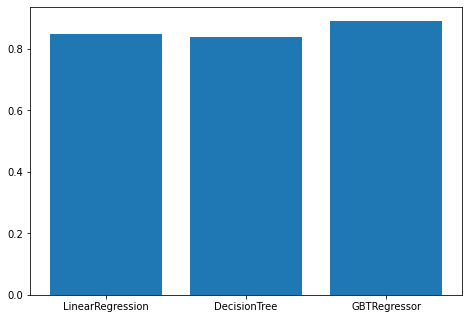

In [198]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = df.index.values
students = df.Algorithms
ax.bar(langs,students)
plt.show()

KeyboardInterrupt: ignored

In [143]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [ 'temp_Markree',
 'temp_FINNER',
 'temp_Newport',
 'temp_CLAREMORRIS',
 'temp_BELMULLET',
 ], outputCol = 'features')
vector_temp_df = vectorAssembler.transform(temp)
vector_temp_df = vector_temp_df.select(['features', 'temp_sligo_Y3H'])
vector_temp_df.show(3, truncate=False)

+---------------------+--------------+
|features             |temp_sligo_Y3H|
+---------------------+--------------+
|[5.0,5.4,5.7,5.7,5.0]|3.8           |
|[2.0,5.3,3.0,0.4,2.5]|4.3           |
|[1.9,4.2,3.8,2.7,3.2]|2.0           |
+---------------------+--------------+
only showing top 3 rows



In [144]:
splits = vector_temp_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [163]:
from pyspark.ml.regression import GBTRegressor
#train
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'temp_sligo_Y3H', maxIter=120)
gbt_model = gbt.fit(train_df)
#test


gbt_predictions = gbt_model.transform(test_df)

gbt_predictions.select('prediction', 'temp_sligo_Y3H', 'features').show(5)

gbt_evaluator = RegressionEvaluator(
    labelCol="temp_sligo_Y3H", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="temp_sligo_Y3H", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
print("R2 on test data = %g" % r2)

+-----------------+--------------+--------------------+
|       prediction|temp_sligo_Y3H|            features|
+-----------------+--------------+--------------------+
|-1.66699206777812|          -1.0|[-8.2,0.0,0.5,-3....|
|-1.66699206777812|           1.9|[-7.0,-2.0,0.1,-2...|
|-1.66699206777812|           3.4|[-6.7,-1.7,-0.8,-...|
|-1.66699206777812|          -4.3|[-6.5,-2.9,-0.1,-...|
|-1.66699206777812|          -6.5|[-6.2,-2.3,0.2,-2...|
+-----------------+--------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.88785
R2 on test data = 0.851763
